# Dataset 

Nella prima parte del codice vado a creare il dataframe con i path relativi alle varie immagini, divise per T1/T2/OTHER and FLAIR.

Nella seconda vado a creare le immagini andando ad inserire i tre dicom del pre-retrive nei tre canali RGB in modo da andare a ricreare "una visione 3D".


## Dataframe 

In [122]:
from pymongo import MongoClient
import pandas as pd
import seaborn as sns

In [118]:
username = "adminuser"
password  = "adminpw"
client = MongoClient('10.224.68.10', 30015,password = password ,username = username )
db = client.get_database("pre_retrieve_ONWAY")

In [119]:
df = pd.DataFrame(list(
        db.dicom_series.find(
            {"is_brain_manual": {"$in": [ True]},            },
            {f: 1 for f in ("is_brain_manual", "SeriesDescription", "file_path","sequence_type_manual")} #dictionary comprehension 
        )
    ))

[]

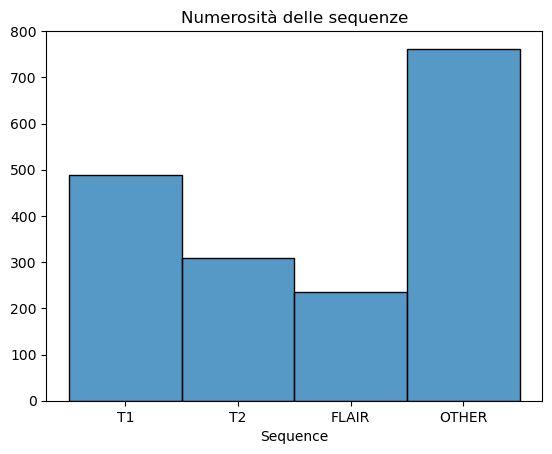

In [141]:
ax = sns.histplot(data = df,x = "sequence_type_manual")
ax.set(xlabel='Sequence', ylabel='',title = "Numerosità delle sequenze")
ax.plot()

In [120]:
T1 = df.loc[df["sequence_type_manual"] == "T1"]
T2 = df.loc[df["sequence_type_manual"] == "T2"]
FLAIR = df.loc[df["sequence_type_manual"] == "FLAIR"]
OTHER = df.loc[df["sequence_type_manual"] == "OTHER"]

In [121]:
T1_path = list(T1["file_path"].str.replace("/mnt/databaseRICERCA_SDN/ONWAY/PACS","/home/jovyan/Verdicchio/ONWAY_DATA"))
T2_path = list(T2["file_path"].str.replace("/mnt/databaseRICERCA_SDN/ONWAY/PACS","/home/jovyan/Verdicchio/ONWAY_DATA"))
FLAIR_path = list(FLAIR["file_path"].str.replace("/mnt/databaseRICERCA_SDN/ONWAY/PACS","/home/jovyan/Verdicchio/ONWAY_DATA"))
OTHER_path = list(OTHER["file_path"].str.replace("/mnt/databaseRICERCA_SDN/ONWAY/PACS","/home/jovyan/Verdicchio/ONWAY_DATA"))


In [81]:
pd.DataFrame.from_dict({"T1": T1_path,"T2": T2_path,"FLAIR": FLAIR_path,"OTHER": OTHER_path},orient='index').T.to_csv("/home/jovyan/Verdicchio/Progetti/Sequence-Clasification/dataset.csv", sep = ";")

## Image Creation

Vado a creare delle immagini del tipo : 

<img src="./prova.jpg" />

In cui sui tre canali ci sono le tre immagini del pre-retrive.

NB: va chiarita la questione della posizione, ovviamente per rendere il tutto omogeneo possibile dovrei avere : 


|Canale| Stack image|
| :---        |    :----:   |
| 1      |  25 |
| 2      |  50 |
| 3      |  75 |


In [103]:
import pandas as pd
import matplotlib.pyplot as plt
import sys
sys.path.append("../")
import numpy as np 
from script.dataset_prep import Dataset_preparation
import os 
from tqdm.notebook import tqdm

In [104]:
Dataset_path = pd.read_csv("../dataset.csv",sep = ";")
T1 = list(Dataset_path["T1"].dropna())
T2 = list(Dataset_path["T2"].dropna())
FLAIR = list(Dataset_path["FLAIR"].dropna())
OTHER = list(Dataset_path["OTHER"].dropna())

In [105]:
def z_normalization(img):
    return (img -np.mean(img))/np.std(img)

In [115]:
def create_image(sequence,path_save):
    for path in tqdm(sequence):
        img = [] 
        for i in [os.path.join(path,x) for x in sorted(os.listdir(path))] : 
            file = Dataset_preparation(i)
            img.append(file.load_image())
            I = z_normalization(np.moveaxis(np.array(img), 0, -1))
            file_name = os.path.basename(os.path.dirname(i)) 
        np.save(os.path.join(path_save,file_name),I)

In [116]:
create_image(T1,"/home/jovyan/Verdicchio/ONWAY_DATA/Dataset/T1/")
create_image(T2,"/home/jovyan/Verdicchio/ONWAY_DATA/Dataset/T2/")
create_image(FLAIR,"/home/jovyan/Verdicchio/ONWAY_DATA/Dataset/FLAIR/")
create_image(OTHER,"/home/jovyan/Verdicchio/ONWAY_DATA/Dataset/OTHER/")

  0%|          | 0/488 [00:00<?, ?it/s]

  0%|          | 0/309 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/762 [00:00<?, ?it/s]